<a href="https://colab.research.google.com/github/treezy254/Data-Science-Prep/blob/master/spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


In [2]:
import pandas as pd
import numpy as np 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [4]:
spotify = pd.read_csv('spotify.csv')
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat)
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.

def group_split(X, y, group, train_size=0.75):
  splitter = GroupShuffleSplit(train_size=train_size)
  train, test = next(splitter.split(X, y, groups=group))
  return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.fit_transform(X_valid)
y_train = y_train/100
y_valid = y_valid/100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [8]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience = 5,
    restore_best_weights = True,
)

Epoch 1/50
48/48 [==============================] - 1s 10ms/step - loss: 0.2200 - val_loss: 0.2083
Epoch 2/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1953 - val_loss: 0.2044
Epoch 3/50
48/48 [==============================] - 0s 6ms/step - loss: 0.1911 - val_loss: 0.2046
Epoch 4/50
48/48 [==============================] - 0s 7ms/step - loss: 0.1896 - val_loss: 0.2036
Epoch 5/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1878 - val_loss: 0.2032
Epoch 6/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1859 - val_loss: 0.2021
Epoch 7/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1841 - val_loss: 0.2032
Epoch 8/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1831 - val_loss: 0.2019
Epoch 9/50
48/48 [==============================] - 0s 10ms/step - loss: 0.1827 - val_loss: 0.2014
Epoch 10/50
48/48 [==============================] - 0s 9ms/step - loss: 0.1813 - val_loss: 0.2019
Epoch 11/50
48/4

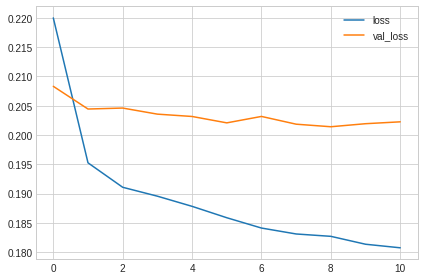

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae'
)

history = model.fit(
    X_train, y_train,
    validation_data = (X_valid, y_valid),
    batch_size=512,
    epochs = 50,
    callbacks = [early_stopping]
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

